In [1]:
import astropy.units as u
import numpy as np
import doodads as dd
dd.init()

# Bobcat evolution cool-down plots

In [2]:
tabulated_masses = np.unique(dd.BOBCAT_EVOLUTION_TABLES_M0.mass['mass_Msun']) * u.Msun
tabulated_ages = np.unique(dd.BOBCAT_EVOLUTION_TABLES_M0.mass['age_Gyr']) * u.Gyr

Unmodified subsets of the properties at fixed masses (and varying age) are plotted to show their $T_\text{eff}$ ($= T_\text{evol}$ here) and surface gravity $g$. The same properties are calculated through `dd.BOBCAT_EVOLUTION_M0.mass_age_to_properties` and overplotted to show agreement.

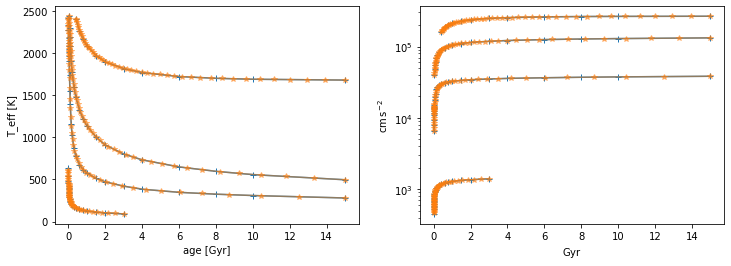

In [3]:
fig, (tax, gax) = plt.subplots(ncols=2, figsize=(12, 4))
for test_mass in tabulated_masses[::20]:
    mask = dd.BOBCAT_EVOLUTION_TABLES_M0.mass['mass_Msun'] == test_mass.to(u.Msun).value
    subset = dd.BOBCAT_EVOLUTION_TABLES_M0.mass[mask]
    tax.plot(subset['age_Gyr'], subset['T_eff_K'], '+-C0')
    gax.plot(subset['age_Gyr'], 10**subset['log_g_cm_per_s2'] * u.cm/u.s**2, '+-C0')

    interp_ages = np.logspace(np.log10(np.min(subset['age_Gyr'])), np.log10(np.max(subset['age_Gyr']))) * u.Gyr
    if interp_ages[-1] > np.max(subset['age_Gyr']) * u.Gyr:
        interp_ages[-1] = np.max(subset['age_Gyr']) * u.Gyr
    T_evol, T_eff, surface_gravity = dd.BOBCAT_EVOLUTION_M0.mass_age_to_properties(
        test_mass,
        interp_ages,
    )
    tax.plot(interp_ages, T_eff, '*-C1', alpha=0.5)
    gax.plot(interp_ages, surface_gravity, '*-C1', alpha=0.5)

tax.set(
    xlabel='age [Gyr]',
    ylabel='T_eff [K]',
)
_ = gax.set(yscale='log')

# Using $T_\text{eq} \ne T_\text{evol}$

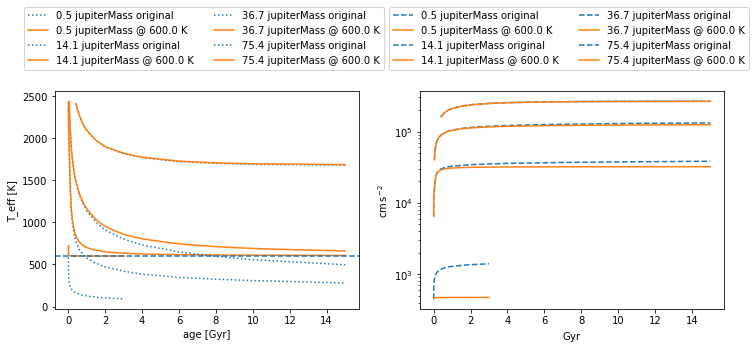

In [4]:
T_eq = 600*u.K
fig, (tax, gax) = plt.subplots(ncols=2, figsize=(12, 4))
for test_mass in tabulated_masses[::20]:
    mask = dd.BOBCAT_EVOLUTION_TABLES_M0.mass['mass_Msun'] == test_mass.to(u.Msun).value
    subset = dd.BOBCAT_EVOLUTION_TABLES_M0.mass[mask]
    tax.plot(subset['age_Gyr'], subset['T_eff_K'], ls=':', c='C0', label=f"{test_mass.to(u.Mjup):3.1f} original")
    gax.plot(subset['age_Gyr'], 10**subset['log_g_cm_per_s2'] * u.cm/u.s**2, '--C0', label=f"{test_mass.to(u.Mjup):3.1f} original")
    interp_ages = np.logspace(np.log10(np.min(subset['age_Gyr'])), np.log10(np.max(subset['age_Gyr']))) * u.Gyr
    if interp_ages[-1] > np.max(subset['age_Gyr']) * u.Gyr:
        interp_ages[-1] = np.max(subset['age_Gyr']) * u.Gyr
    T_evol, T_eff, surface_gravity = dd.BOBCAT_EVOLUTION_M0.mass_age_to_properties(
        test_mass,
        interp_ages,
        T_eq=T_eq
    )
    tax.plot(interp_ages, T_eff, '-C1', label=f"{test_mass.to(u.Mjup):3.1f} @ {T_eq}")
    gax.plot(interp_ages, surface_gravity, '-C1', label=f"{test_mass.to(u.Mjup):3.1f} @ {T_eq}")

tax.set(
    xlabel='age [Gyr]',
    ylabel='T_eff [K]',
)
gax.set(yscale='log')
tax.axhline(T_eq, ls='--')
tax.legend(loc=(-0.1, 1.1), ncol=2)
gax.legend(loc=(-0.1, 1.1), ncol=2)

# Bobcat synthetic photometry comparison plots

In [5]:
phot_tbl = dd.ref.bobcat.load_bobcat_photometry('photometry_tables/mag_table+0.0')

In [6]:
phot_masses = np.unique(phot_tbl['mass_Mjup']) * u.Mjup

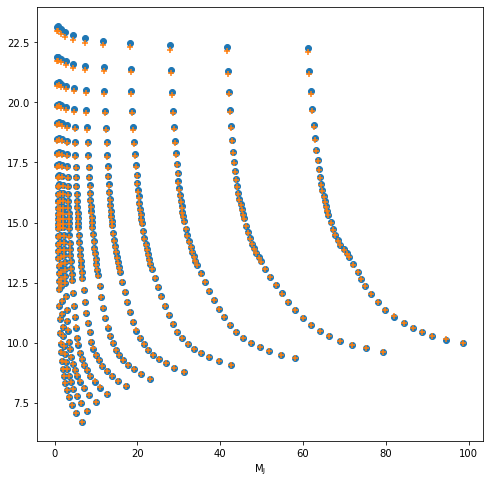

In [7]:
plt.figure(figsize=(8, 8))
plt.scatter(phot_tbl['mass_Mjup'] * u.Mjup, phot_tbl['mag_MKO_Lprime'], label='Bobcat reference')

masses, mags = np.zeros(len(phot_tbl)) * u.Mjup, np.zeros(len(phot_tbl))
for idx, row in enumerate(phot_tbl):
    T_eff = row['T_eff_K'] * u.K
    g = 10**row['log_g_cm_per_s2'] * u.cm/u.s**2
    mass = row['mass_Mjup'] * u.Mjup
    try:
        spec = dd.BOBCAT_SPECTRA_M0.get(
            temperature=T_eff,
            surface_gravity=g,
            mass=mass,
        )
    except dd.ref.model_grids.BoundsError:
        print(f"OOB: {T_eff=} {g=} {mass=}")
        masses[idx] = np.nan
        mags[idx] = np.nan
        continue
    masses[idx] = mass
    mag = dd.VEGA_BOHLIN_GILLILAND_2004.magnitude(spec, dd.MKO.Lprime)
    mags[idx] = mag
    
plt.scatter(masses, mags, marker='+')

Some kind of systematic error exists at low magnitudes, but the fractional error in magnitude is small. Small changes in filter width can produce this sort of error, as can different/any atmosphere models, different Vega models, etc.

To verify:

Text(0, 0.5, 'Number of table rows')

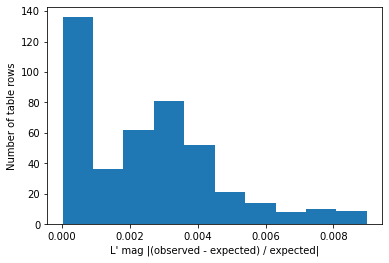

In [8]:
_ = plt.hist(np.abs((mags - phot_tbl['mag_MKO_Lprime'])/phot_tbl['mag_MKO_Lprime']))
plt.xlabel('L\' mag |(observed - expected) / expected|')
plt.ylabel('Number of table rows')

The maximum relative error in magnitude is < 1%:

In [9]:
np.nanmax(np.abs((mags - phot_tbl['mag_MKO_Lprime'])/phot_tbl['mag_MKO_Lprime']))

0.008985546387133265